# Homework 4: Modeling Text Data

### Team Member 1:
* Name: Shiemi Lim

### Team Member 2:  
* Name: Sheallika Sign

### Also Team member: Andreas Mueller


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

In [1]:
# Import libraries

%matplotlib inline
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt
import sklearn
import pandas as pd 

import os
import csv
import math
# import nltk
import re
import itertools

from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import MaxAbsScaler
from IPython.display import Image
# from mglearn.tools import visualize_coefficients
from sklearn.cluster import KMeans
# nltk.download('all', halt_on_error=False)

In [2]:
# Load data
data_path = os.path.join("Vision_Zero_Entry.csv")
df = pd.read_csv(data_path, index_col=False, header=0)
df.head()

,﻿X,Y,OBJECTID,GLOBALID,REQUESTID,REQUESTTYPE,REQUESTDATE,STATUS,STREETSEGID,COMMENTS,USERTYPE
0,-71.071329,42.332161,15607,NaN,15607.0,bike facilities don't exist or need improvement,2016-01-19T22:14:26.000Z,Unassigned,0,the roadway is super wide here with no lane ma...,bikes
1,-71.067764,42.374244,15608,NaN,15608.0,"the wait for the ""Walk"" signal is too long",2016-01-19T22:55:29.000Z,Unassigned,0,As someone who walks from SE of the intersecti...,walks
2,-71.066077,42.374768,15609,NaN,15609.0,people cross away from the crosswalks,2016-01-19T22:57:09.000Z,Unassigned,0,I'm one of those people. Many people walk nort...,walks
3,-71.152978,42.345312,16007,NaN,16007.0,people speed,2016-01-19T23:33:20.000Z,Unassigned,0,NaN,walks
4,-71.070658,42.351921,16008,NaN,16008.0,people don't yield while turning,2016-01-19T23:39:45.000Z,Unassigned,0,People do not understand which lane to move in...,drives


In [3]:
df.REQUESTTYPE.value_counts()

of something that is not listed here                                                                         1432
people speed                                                                                                 1232
bike facilities don't exist or need improvement                                                              1136
people run red lights / stop signs                                                                            792
people don't yield while turning                                                                              645
people double park their vehicles                                                                             635
it’s hard to see / low visibility                                                                             433
people don't yield while going straight                                                                       364
sidewalks/ramps don't exist or need improvement                                         

There are some empty columns, let's delete them. We'll also fix the html in some of them.

In [4]:
df = df.dropna(subset=['COMMENTS'])
df['REQUESTTYPE'] = df.REQUESTTYPE.str.replace(".*</span>&nbsp;","")
df.REQUESTTYPE.value_counts()

of something that is not listed here                     1427
bike facilities don't exist or need improvement           782
people speed                                              746
people run red lights / stop signs                        662
people don't yield while turning                          461
people double park their vehicles                         430
it’s hard to see / low visibility                         392
sidewalks/ramps don't exist or need improvement           303
people don't yield while going straight                   264
people cross away from the crosswalks                     255
the roadway surface needs improvement                     222
the wait for the "Walk" signal is too long                209
there are no bike facilities or they need maintenance     128
there's not enough time to cross the street               122
it's too far / too many lanes to cross                     84
there are no sidewalks or they need maintenance            40
the road

In [5]:
# Replace variables with better renaming
df.REQUESTTYPE.replace("there are no bike facilities or they need maintenance", "bike facilities don't exist or need improvement", inplace=True)
df.REQUESTTYPE.replace('people have to wait too long for the "Walk" signal', 'the wait for the "Walk" signal is too long', inplace=True)
df.REQUESTTYPE.replace("sidewalks/ramps don't exist or need improvement", "there are no sidewalks or they need maintenance", inplace=True)
df.REQUESTTYPE.replace("the roadway surface needs maintenance", "the roadway surface needs improvement", inplace=True)
df.REQUESTTYPE.replace("people have to cross too many lanes / too far", "it's too far / too many lanes to cross", inplace=True)
df.REQUESTTYPE.replace("people are not given enough time to cross the street", "there's not enough time to cross the street", inplace=True)
df.REQUESTTYPE.replace("it’s hard for people to see each other", "it’s hard to see / low visibility", inplace=True)

In [6]:
df.REQUESTTYPE.value_counts()

of something that is not listed here               1427
bike facilities don't exist or need improvement     910
people speed                                        746
people run red lights / stop signs                  662
people don't yield while turning                    461
people double park their vehicles                   430
it’s hard to see / low visibility                   420
there are no sidewalks or they need maintenance     343
people don't yield while going straight             264
the roadway surface needs improvement               256
people cross away from the crosswalks               255
the wait for the "Walk" signal is too long          239
there's not enough time to cross the street         131
it's too far / too many lanes to cross              111
Name: REQUESTTYPE, dtype: int64

In [7]:
# Deduplicate
df.drop_duplicates(['REQUESTTYPE', 'COMMENTS'], inplace=True)

In [8]:
df.REQUESTTYPE.value_counts()

of something that is not listed here               1402
bike facilities don't exist or need improvement     817
people speed                                        742
people run red lights / stop signs                  649
people don't yield while turning                    452
people double park their vehicles                   423
it’s hard to see / low visibility                   412
there are no sidewalks or they need maintenance     339
people don't yield while going straight             256
people cross away from the crosswalks               255
the roadway surface needs improvement               250
the wait for the "Walk" signal is too long          228
there's not enough time to cross the street         131
it's too far / too many lanes to cross              108
Name: REQUESTTYPE, dtype: int64

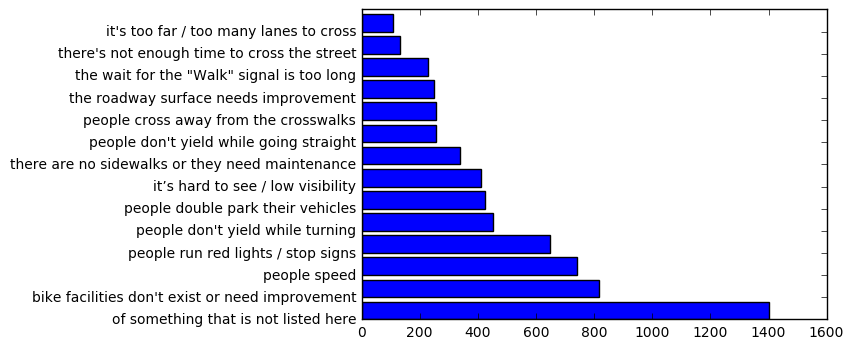

In [9]:
# Let's visualize the class distrbution
distr = df.REQUESTTYPE.value_counts()
plt.barh(np.arange(len(distr)), distr)
# plt.yticks(range(14),req_type);
plt.yticks(np.arange(len(distr)), list(distr.index));

Notice there is a big "other" category. We will look into this later. 

In [10]:
X = df.COMMENTS
y = df.REQUESTTYPE

In [11]:
# Pre-process words
stemmer = SnowballStemmer("english")

In [12]:
X = X.str.replace('[^\w\s]','')
X = X.str.lower()

# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

In [13]:
#Let's split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=45)

In [15]:
# Apply stemming to training set
def stem_word(phrase):
    return " ".join([stemmer.stem(word) for word in word_tokenize(phrase)])

stemmed_X_train = X_train.copy()
stemmed_X_train = stemmed_X_train.apply(stem_word)

#### Grid search for logistic regression

In [16]:
X_train.head()

1820                parking in the bike lane all the time
5469    people double park when the road is already na...
7754    the construction project on berklee here has t...
3060                            is this a sidewalk or nah
7284    cars turning left from columbus have focus att...
Name: COMMENTS, dtype: object

In [17]:
stemmed_X_train.head()

1820                   park in the bike lane all the time
5469    peopl doubl park when the road is alreadi narr...
7754    the construct project on berkle here has taken...
3060                            is this a sidewalk or nah
7284    car turn left from columbus have focus attent ...
Name: COMMENTS, dtype: object

In [19]:
# TfidfVectorizer actually gives a little better performance here, 54.7% vs 52.3%
# As a first model, I would usually use CountVectorizer.
pipe_base_model_cv = make_pipeline(TfidfVectorizer(),
                         LogisticRegressionCV(scoring='f1_macro', n_jobs=-1, multi_class='multinomial', class_weight='balanced'))
pipe_base_model_cv.fit(X_train, y_train)
y_pred = pipe_base_model_cv.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))
print(pipe_base_model_cv.named_steps['logisticregressioncv'].C_)

0.530166448447
[ 2.7825594  2.7825594  2.7825594  2.7825594  2.7825594  2.7825594
  2.7825594  2.7825594  2.7825594  2.7825594  2.7825594  2.7825594
  2.7825594  2.7825594]


Accuracy on test set

In [20]:
y_pred = pipe_base_model_cv.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
print(score)

0.530166448447


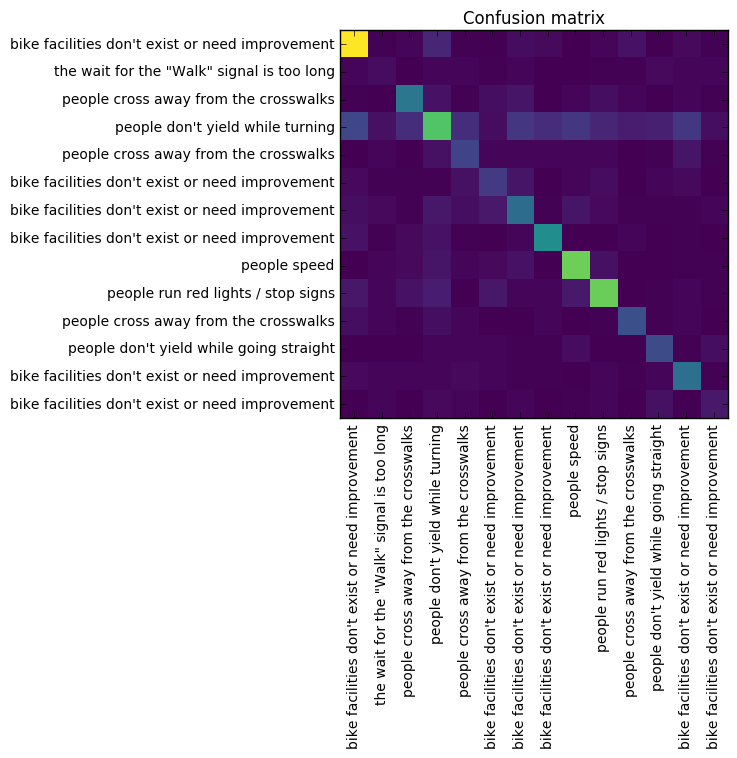

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.yticks(range(len(cm)), y.astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y.astype('unicode'), rotation=90)
plt.title('Confusion matrix')
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


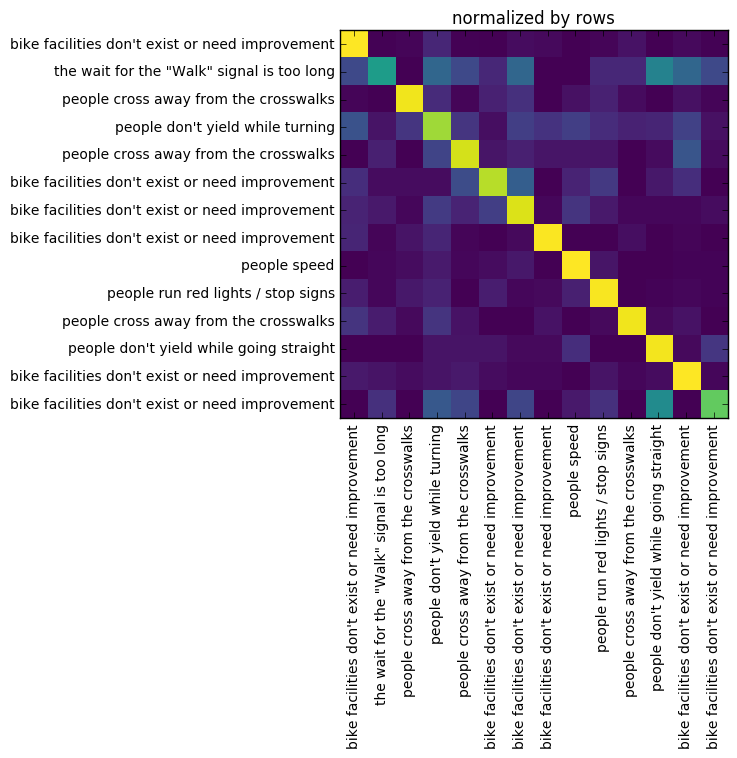

In [22]:
cm = normalize(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.yticks(range(len(cm)), y.astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y.astype('unicode'), rotation=90)
plt.title('normalized by rows')
plt.show()

# Plot some model coefficients

In [23]:
feature_names = pipe_base_model_cv.named_steps['tfidfvectorizer'].get_feature_names()

In [24]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")

In [25]:
n_classes = len(pipe_base_model_cv.named_steps['logisticregression'].classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), pipe_base_model.named_steps['logisticregression'].coef_, y.astype('unicode')):
    ax.set_title(label)
    plot_important_features(coef, np.array(feature_names), ax=ax)
plt.tight_layout()

KeyError: 'logisticregression'

Looks reasonable :)

# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

In [26]:
# Try Ngrams model
# Add your code for task 3 here. You may use multiple cells. 
vectorizer_ngrams = CountVectorizer(ngram_range=(1,10), stop_words="english", lowercase=True, min_df=2)
x_train_vectorized_ngrams = vectorizer_ngrams.fit_transform(X_train)
x_test_vectorized_ngrams = vectorizer_ngrams.transform(X_test)

In [27]:
x_train_vectorized_ngrams

<4848x13537 sparse matrix of type '<class 'numpy.int64'>'
	with 94718 stored elements in Compressed Sparse Row format>

In [28]:
x_test_vectorized_ngrams

<1616x13537 sparse matrix of type '<class 'numpy.int64'>'
	with 26218 stored elements in Compressed Sparse Row format>

In [29]:
lr_ngrams = LogisticRegression(C=2.783).fit(x_train_vectorized_ngrams, y_train)

y_test_pred_ngrams = lr_ngrams.predict(x_test_vectorized_ngrams)

In [30]:
f1_score(y_test, y_test_pred_ngrams, average="macro")

0.51756666702145915

In [31]:
confusion_matrix(y_test, y_test_pred_ngrams)

array([[154,   1,   0,  27,   0,   1,   3,   4,   0,   6,   4,   0,   3,
          1],
       [  7,   1,   0,   6,   1,   1,   1,   0,   0,   4,   0,   3,   2,
          1],
       [  2,   0,  45,  26,   2,   2,   6,   1,   4,  11,   2,   0,   2,
          0],
       [ 39,   0,  11, 196,  11,   4,  13,   7,  26,  20,   3,   8,  12,
          0],
       [  1,   0,   0,  24,  23,   0,   1,   0,   2,   7,   0,   0,   5,
          1],
       [  4,   0,   1,  16,   5,  19,   7,   0,   2,   7,   0,   1,   2,
          0],
       [  9,   1,   1,  25,   4,   6,  48,   1,   8,   6,   0,   2,   1,
          1],
       [  8,   0,   1,  21,   0,   0,   0,  71,   2,   1,   1,   0,   1,
          0],
       [  2,   1,   4,  26,   1,   3,   2,   0, 115,   7,   0,   0,   1,
          0],
       [  9,   0,   6,  23,   0,   6,   0,   3,  14, 123,   0,   1,   0,
          0],
       [  8,   3,   0,   9,   2,   0,   0,   0,   0,   3,  35,   0,   3,
          0],
       [  1,   0,   0,  10,   1,   0,   1, 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


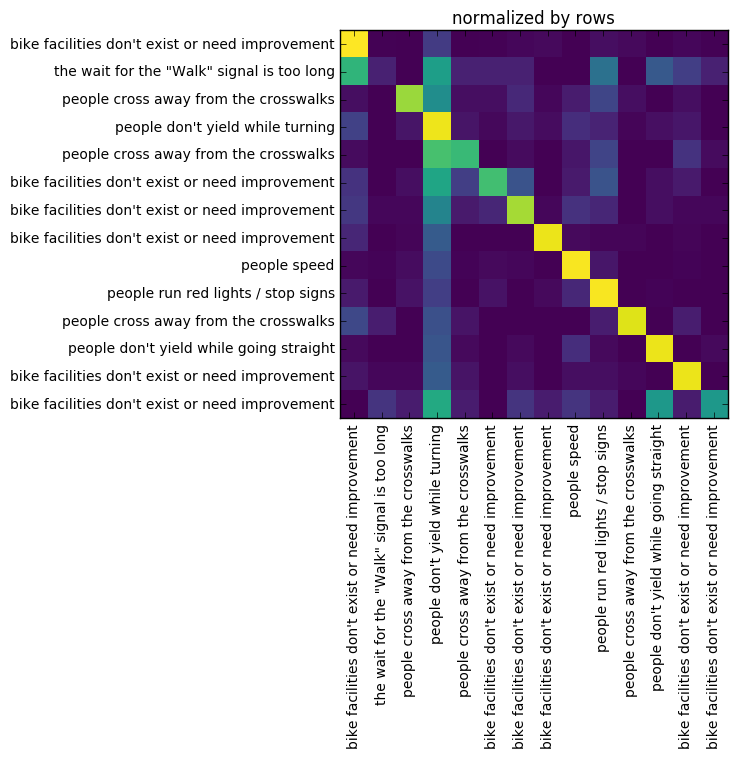

In [32]:
cm = normalize(confusion_matrix(y_test, y_test_pred_ngrams))
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.yticks(range(len(cm)), y.astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y.astype('unicode'), rotation=90)
plt.title('normalized by rows')
plt.show()

In [34]:
#Try character n-grams model
vectorizer_char_ngrams = CountVectorizer(ngram_range=(1,10), stop_words="english", analyzer="char_wb", lowercase=True, min_df=5)
x_train_vectorized_char_ngrams = vectorizer_char_ngrams.fit_transform(stemmed_X_train)
x_test_vectorized_char_ngrams = vectorizer_char_ngrams.transform(X_test)


In [35]:
lr_char_ngrams = LogisticRegression().fit(x_train_vectorized_char_ngrams, y_train)
y_test_pred_char_ngrams = lr_char_ngrams.predict(x_test_vectorized_char_ngrams)

In [36]:
f1_score(y_test, y_test_pred_char_ngrams, average="macro")

0.41761145427715035

In [38]:
confusion_matrix(y_test, y_test_pred_char_ngrams)

array([[115,   1,   0,  64,   0,   3,   3,   1,   2,   9,   4,   0,   2,
          0],
       [  1,   1,   0,  11,   0,   0,   1,   0,   1,   7,   1,   3,   0,
          1],
       [  2,   0,  34,  42,   1,   3,   1,   0,   3,  14,   2,   0,   1,
          0],
       [ 27,   0,  11, 227,   6,   5,  10,   2,  10,  25,  10,   6,  10,
          1],
       [  1,   1,   0,  27,  20,   1,   0,   0,   1,   8,   2,   1,   2,
          0],
       [  2,   0,   2,  34,   0,   9,   5,   1,   1,   6,   0,   3,   1,
          0],
       [  3,   0,   4,  52,   2,   9,  24,   1,   8,   4,   1,   4,   1,
          0],
       [  2,   0,   3,  37,   0,   0,   1,  51,   0,   7,   5,   0,   0,
          0],
       [  5,   0,   1,  64,   1,   1,   4,   0,  69,  14,   0,   1,   1,
          1],
       [  6,   1,   5,  44,   0,   4,   1,   3,   8, 106,   4,   1,   1,
          1],
       [  7,   1,   0,  18,   2,   1,   0,   0,   1,   1,  31,   0,   1,
          0],
       [  1,   0,   0,  11,   3,   0,   0, 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


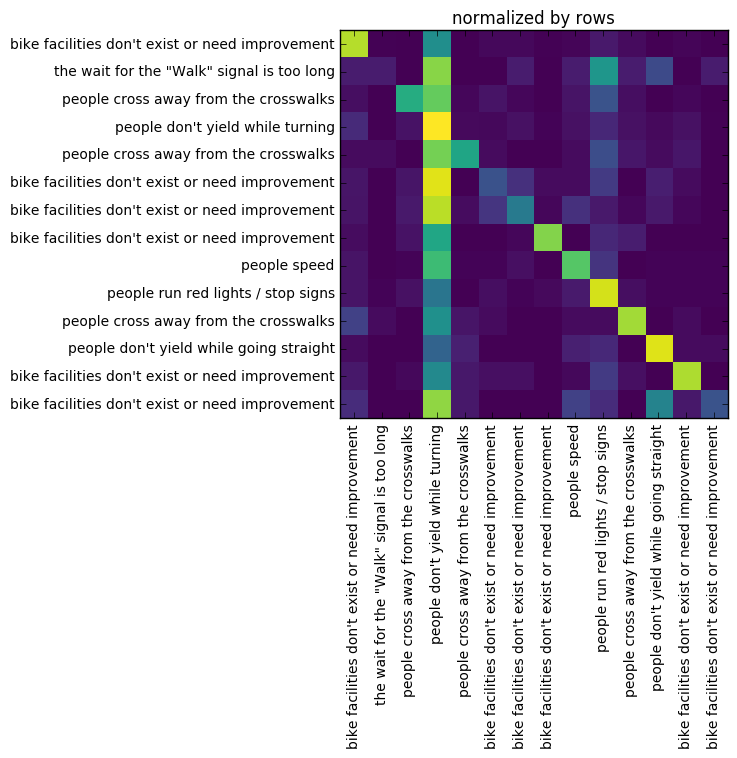

In [39]:
cm = normalize(confusion_matrix(y_test, y_test_pred_char_ngrams))
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest',cmap='viridis')
plt.yticks(range(len(cm)), y.astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y.astype('unicode'), rotation=90)
plt.title('normalized by rows')
plt.show()

In [40]:
pipe_tfidf = make_pipeline(TfidfVectorizer(ngram_range=(1,2), stop_words='english'),
                      LogisticRegression(n_jobs=-1, multi_class='multinomial', class_weight='balanced', C=2.783, solver='lbfgs'))
pipe_tfidf.fit(X_train, y_train)
y_pred = pipe_tfidf.predict(X_test)


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


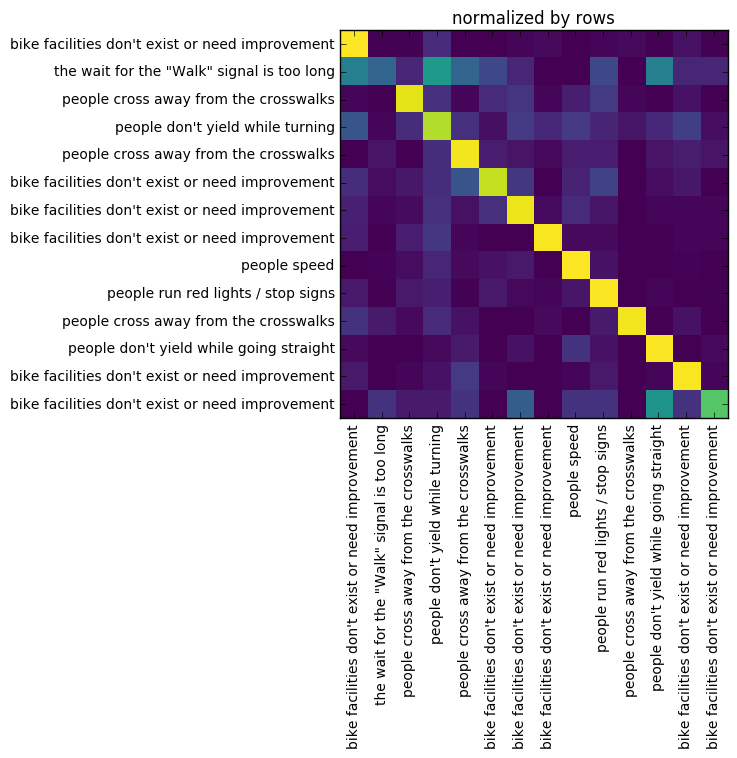

In [41]:
cm = normalize(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(5, 6))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.yticks(range(len(cm)), y.astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y.astype('unicode'), rotation=90)
plt.title('normalized by rows')
plt.show()

In [42]:
f1_score(y_test, y_pred, average="macro")

0.54862765811657865

In [43]:
feature_names = pipe_tfidf.named_steps['tfidfvectorizer'].get_feature_names()

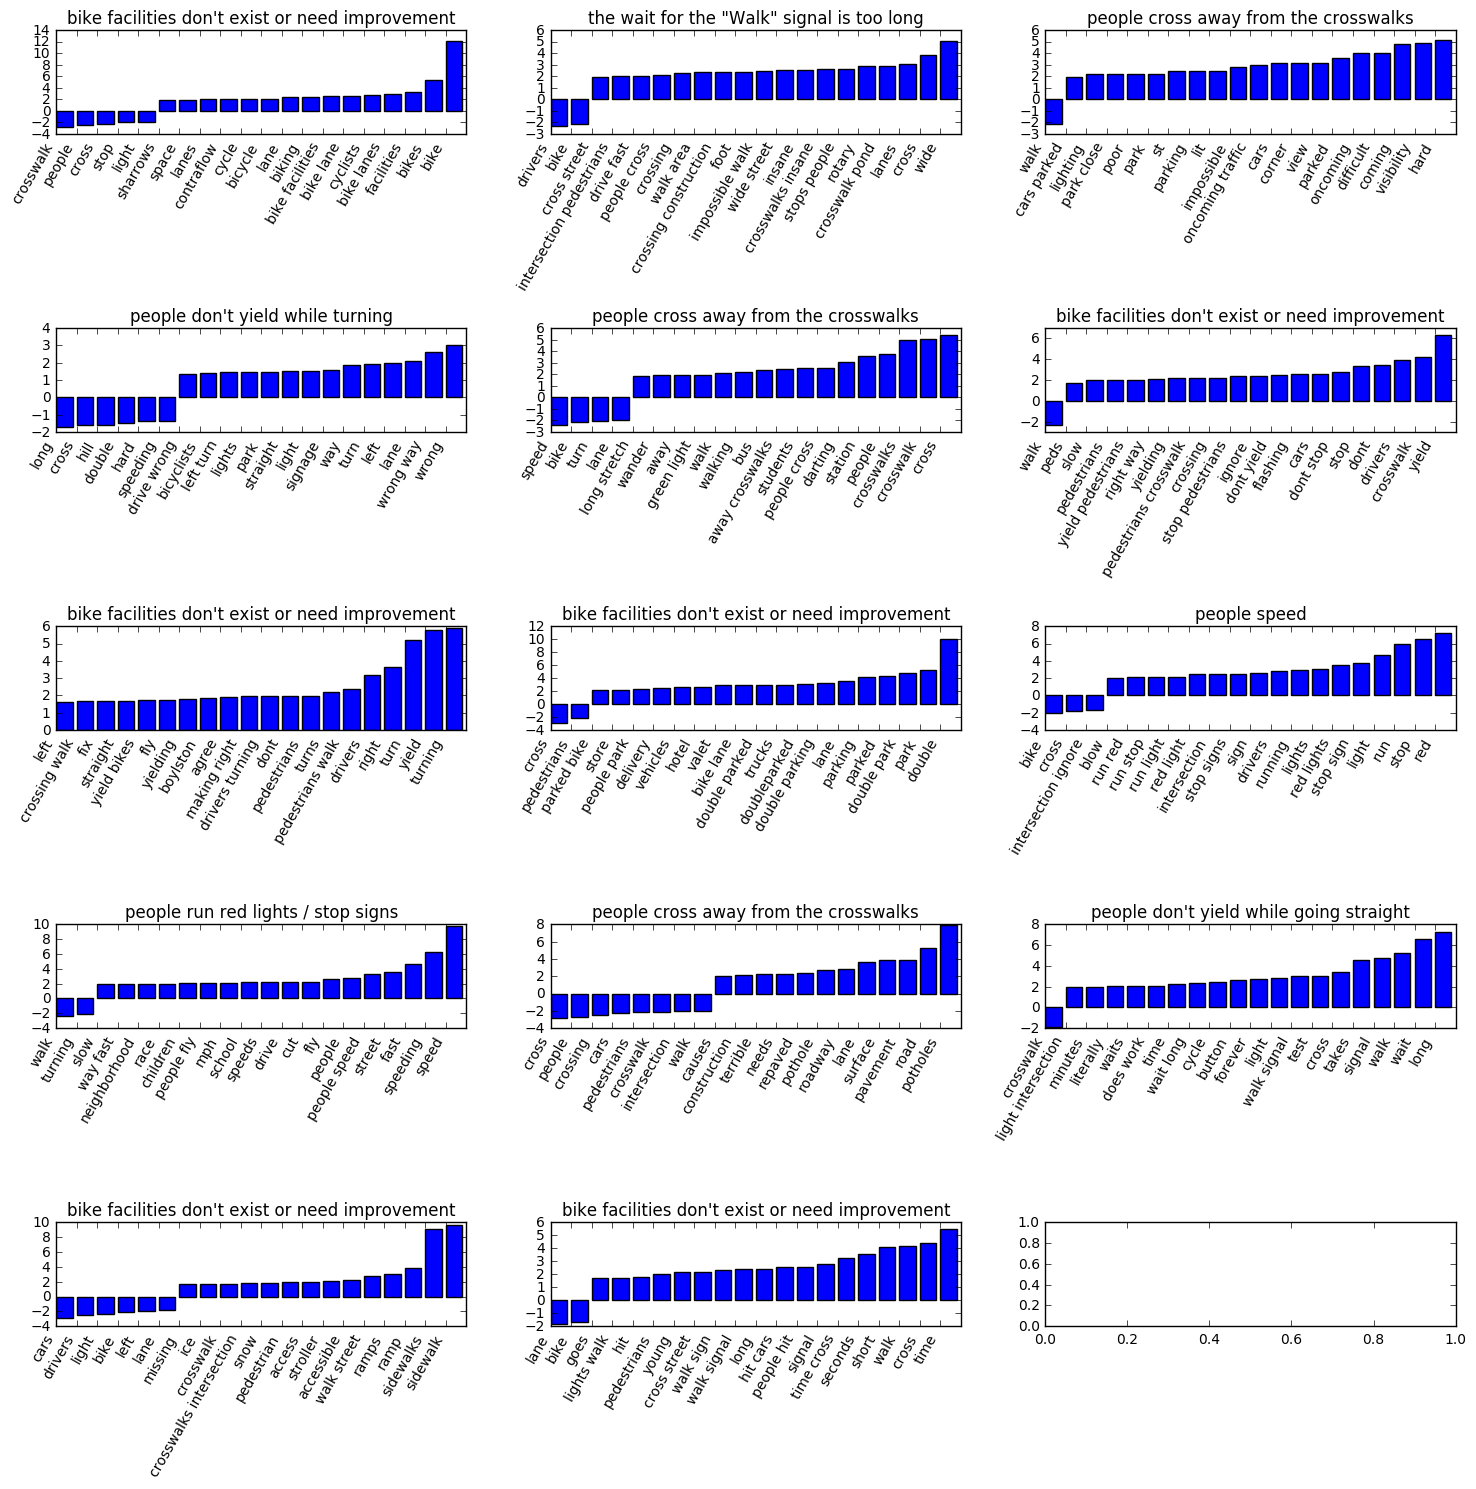

In [44]:
n_classes = len(pipe_tfidf.named_steps['logisticregression'].classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), pipe_tfidf.named_steps['logisticregression'].coef_, y.astype('unicode')):
    ax.set_title(label)
    plot_important_features(coef, np.array(feature_names), ax=ax)
plt.tight_layout()

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

#### LDA

In [45]:
clusterVectorizer = CountVectorizer(ngram_range=(1, 3), min_df=2,stop_words='english').fit(X_train)
X_fullDataVectorized = clusterVectorizer.transform(X_train)

In [46]:

lda = LatentDirichletAllocation(n_topics=10, learning_method="batch",random_state=42)
X_lda = lda.fit_transform(X_fullDataVectorized)

In [47]:
adjusted_rand_score(y_train, np.argmax(X_lda,axis =1))

0.02758079828044762

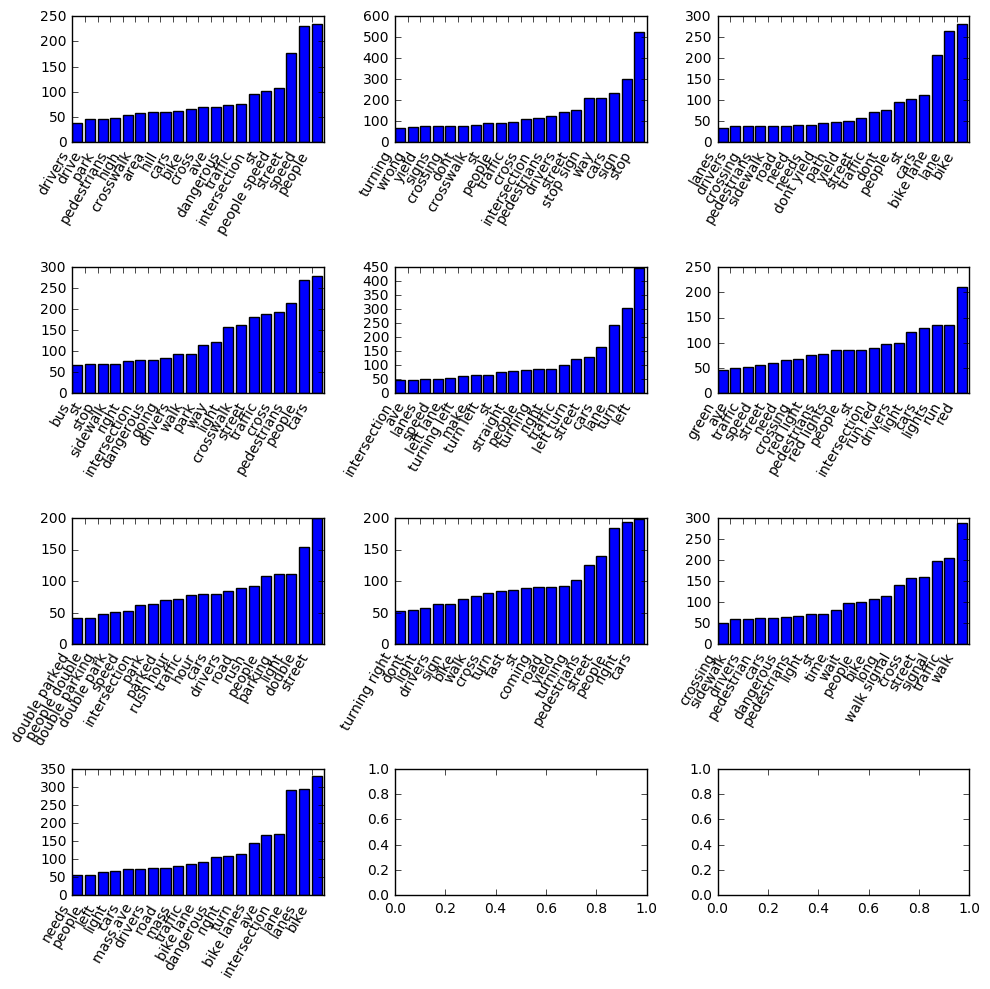

In [48]:
feature_names = np.array(clusterVectorizer.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda.components_):
    plot_important_features(coef, feature_names, ax=ax)
    
plt.tight_layout()

#### NMF

In [49]:
scaler = MaxAbsScaler()
X_fullData_scaled = scaler.fit_transform(X_fullDataVectorized)

In [50]:
nmf = NMF(n_components=10, verbose=0, tol=0.01)
X_nm_scale = nmf.fit_transform(X_fullData_scaled)

print(adjusted_rand_score(y_train, np.argmax(X_nm_scale,axis =1)))



0.14177948908


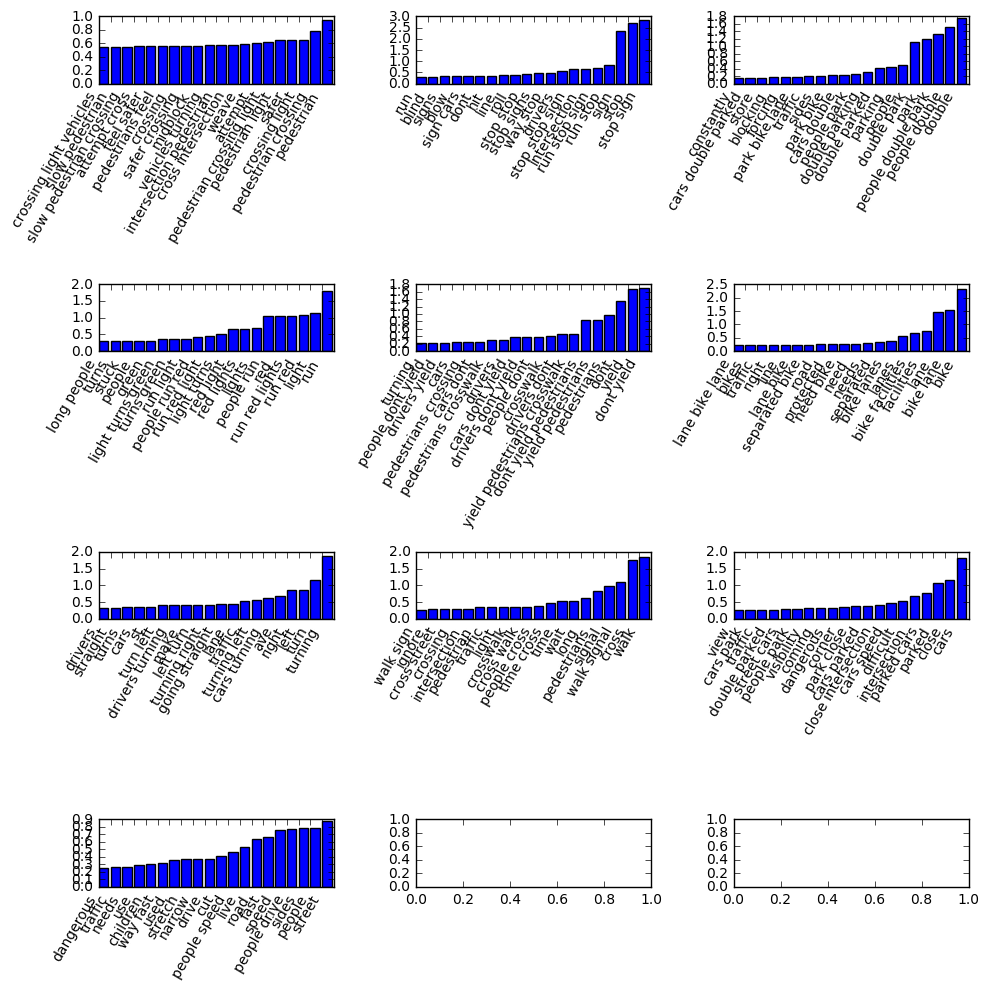

In [51]:
#NMF Visualization 10 components
large_comp_inds = np.argsort(X_nm_scale.mean(axis=0))

feature_names = np.array(clusterVectorizer.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), nmf.components_[large_comp_inds, :]):
    plot_important_features(coef, feature_names,  ax=ax)
    
plt.tight_layout()

#### Kmeans

In [52]:
km = KMeans(n_clusters=14).fit(X_fullData_scaled)

In [53]:
from sklearn.decomposition import TruncatedSVD
comp_pca = TruncatedSVD(n_components=2).fit_transform(X_fullData_scaled)
yLabels=pd.factorize(y_train)

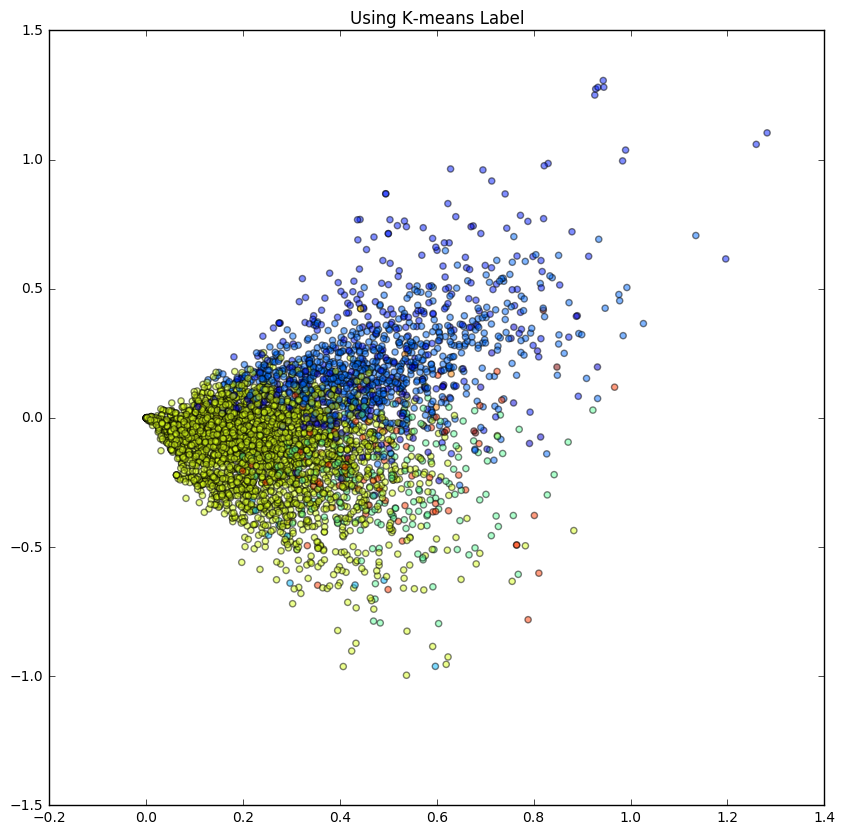

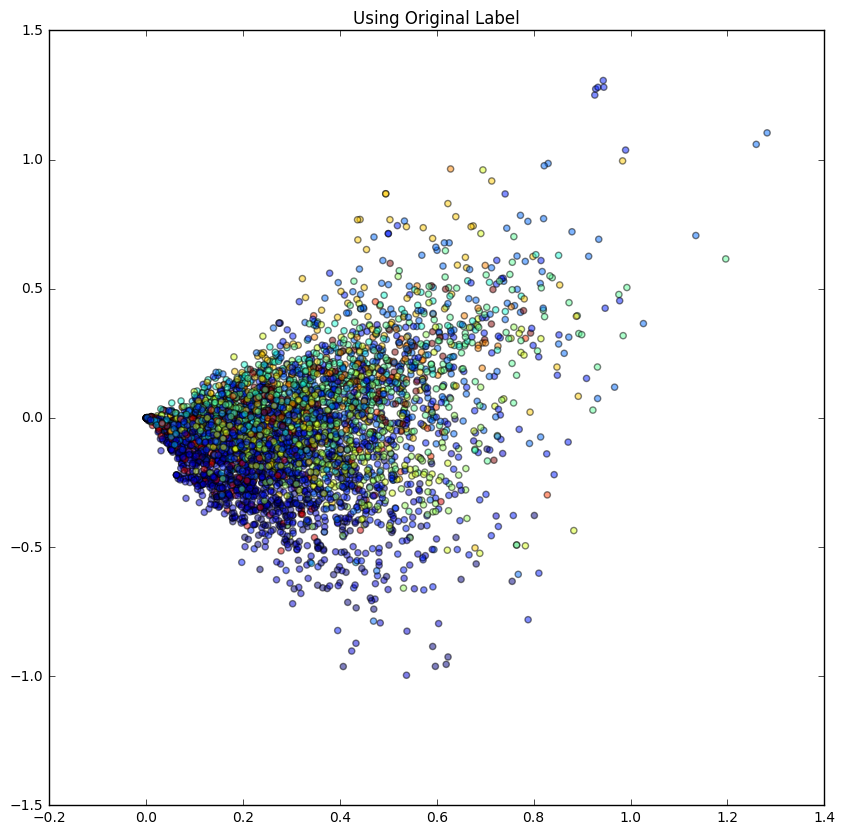

In [54]:


plt.figure(figsize=[10,10])
plt.scatter(comp_pca[:, 0], comp_pca[:, 1], c=km.labels_, alpha=.5)
plt.title('Using K-means Label')
plt.show()
plt.figure(figsize=[10,10])
plt.title('Using Original Label')
plt.scatter(comp_pca[:, 0], comp_pca[:, 1], c=yLabels[0], alpha=.5)
plt.show()



# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

In [205]:
# Add your code for extra credit here. You may use multiple cells. 

